## Importações

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
import seaborn as sns
import matplotlib.pyplot as plt


## Leitura

In [2]:
caminho_jar = "../Transformer/postgresql-42.7.8.jar"

caminho_absoluto_jar = os.path.abspath(caminho_jar)
print(caminho_absoluto_jar)

spark = (
    SparkSession.builder.appName("AnalyticsSilver")
    .config("spark.jars", caminho_absoluto_jar)
    .config("spark.driver.extraClassPath", caminho_absoluto_jar)
    .config("spark.executor.extraClassPath", caminho_absoluto_jar)
    .config("spark.driver.memory", "3g")    
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)

DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "dados_inep"
DB_USER = "admin"
DB_PASS = "l1l2r1r2"
DB_TABLE = "silver.microdados_enem"

jdbc_url = f"jdbc:postgresql://{DB_HOST}:{DB_PORT}/{DB_NAME}"

properties = {
    "user": DB_USER,
    "password": DB_PASS,
    "driver": "org.postgresql.Driver"
}


try:
    df = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "silver.microdados_enem") \
    .option("user", DB_USER) \
    .option("password", DB_PASS) \
    .option("driver", "org.postgresql.Driver") \
    .option("partitionColumn", "nu_inscricao") \
    .option("lowerBound", "0") \
    .option("upperBound", "5000000") \
    .option("numPartitions", "10") \
    .load()
    df.show(5)
except Exception as e:
    print(f"Error connecting to Postgres: {e}")

/home/bertolazi/Faculdade/SDBD_2/SDBD2---INEP/Transformer/postgresql-42.7.8.jar


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/25 21:13:54 WARN Utils: Your hostname, DESKTOP-NR380U6, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/25 21:13:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/25 21:13:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/25 21:13:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+---------------+-------+---------------+-----------+----------------+---------------+---------------+---------+------------+------------------+-------------------+-----------+-----------+--------------+--------------+--------------+--------------+-----------+-----------+-----------+-----------+----------+----------+----------+----------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------+-------------+-------------+-------------+-------------+---------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|nu_inscricao|tp_faixa_etaria|tp_sexo|tp_estado_civil|tp_cor_raca|tp_nacionalidade|tp_st_conclusao|tp_ano_concluiu|tp_escola|in_treineiro|co_municipio_prova| no_municipio_prova|co_uf_prova|sg_uf_prova|tp_presenca_cn|tp_presenca_ch|tp_prese

## 1 Verificação da qualidade dos dados na camada prata:

#### 1.1 Linhas preenchidas por coluna 

/tmp/ipykernel_8163/71317571.py:15: FutureWarning:                              

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")


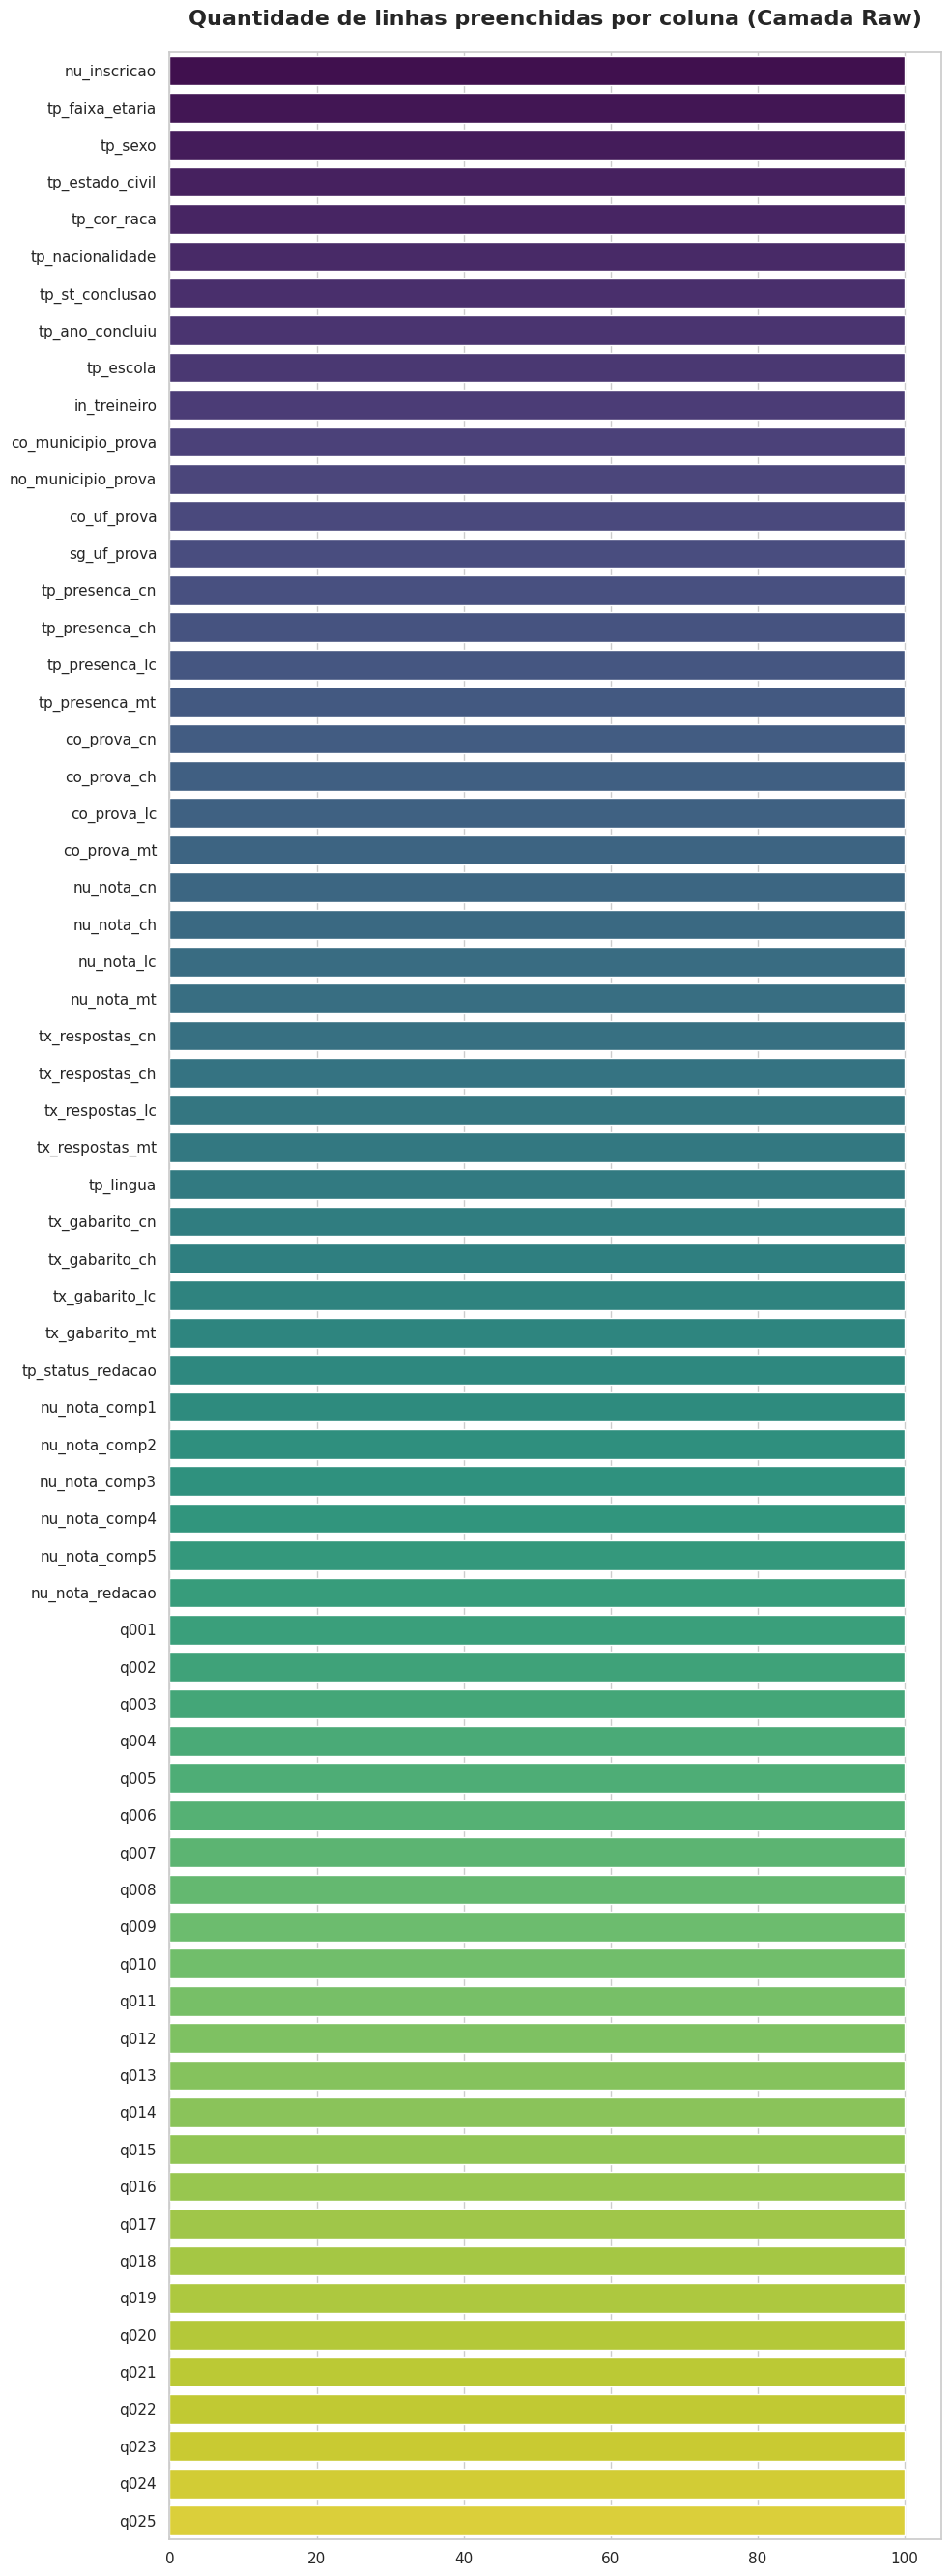

In [3]:
total_sp = df.count()

total_sp_nulos = df.agg(*[F.count(F.col(c)).alias(c) for c in df.columns]).collect()[0].asDict()

coluna_total_nulos = list(total_sp_nulos.keys())
percentual_coluna_nula = [(total_sp_nulos[c]/total_sp) * 100 for c in coluna_total_nulos]

dados_ordenados_completude = sorted(zip(coluna_total_nulos, percentual_coluna_nula), key=lambda x: x[1], reverse=True)

colunas_plot, valores_plot = zip(*dados_ordenados_completude)

plt.figure(figsize=(10, len(colunas_plot) * 0.4))
sns.set_theme(style="whitegrid")

sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")

plt.title('Quantidade de linhas preenchidas por coluna (Camada Raw)', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

##### Explicação

Com base no diagnóstico técnico da camada Raw, o escopo do projeto foi refinado para assegurar a integridade estatística na arquitetura de medalhão, resultando na exclusão das colunas de UF, tornadas redundantes pelo filtro aplicado ao estado de São Paulo, e de todas as variáveis de rastreabilidade escolar. Esta decisão fundamenta-se na constatação de que apenas 75% dos alunos concluintes possuíam dados escolares preenchidos, o que contradiz as diretrizes de governança do INEP e introduziria um viés crítico de dados ausentes; portanto, para a transição à camada Silver, serão promovidos exclusivamente os atributos com 100% de completude, garantindo que as análises de desempenho sejam fundamentadas em registros íntegros e livres de inconsistências sistêmicas.

#### 2.2 Linhas duplicadas 

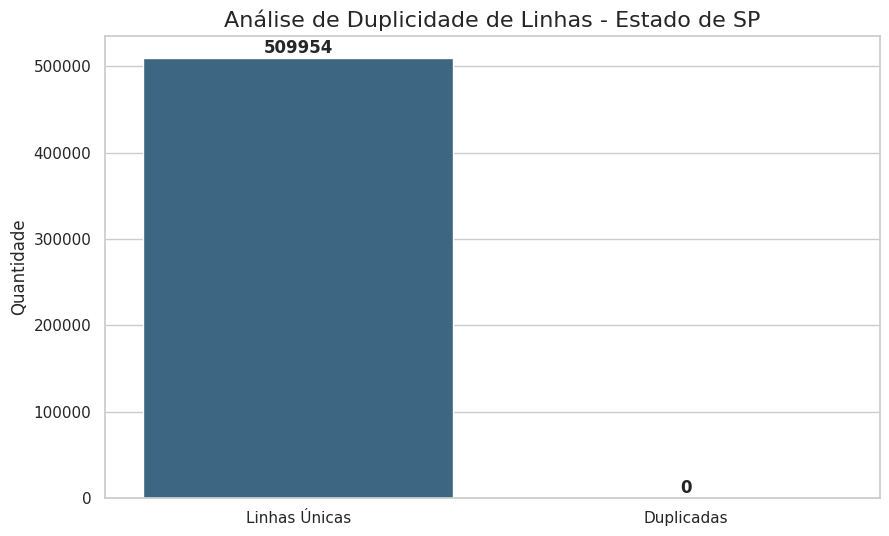

In [4]:
total_linhas = df.count()
total_linhas_unicas = df.distinct().count()
total_duplicados = total_linhas - total_linhas_unicas

categorias = ['Linhas Únicas', 'Duplicadas']
valores = [total_linhas_unicas, total_duplicados]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=categorias, y=valores, hue=categorias, palette='viridis', legend=False)

for i, v in enumerate(valores):
    ax.text(i, v + (max(valores)*0.01), str(v), ha='center', fontweight='bold')

plt.title('Análise de Duplicidade de Linhas - Estado de SP', fontsize=16)
plt.ylabel('Quantidade')
plt.show()

##### Explicação

A revalidação da unicidade de registros após a ingestão dos dados no ambiente de banco de dados confirmou a total ausência de duplicidade, mantendo a integridade observada inicialmente na camada Raw. Embora a análise preliminar já indicasse um dataset íntegro, a permanência deste teste no pipeline serve como uma trava de segurança crítica para assegurar que o processo de migração e carga (ETL) não introduziu redundâncias sistêmicas. Esta consistência garante que cada registro represente um candidato único, preservando a exatidão do espaço amostral necessário para as análises estatísticas de alta fidelidade que serão conduzidas nas camadas superiores da arquitetura.

#### 2.3 Análise de Outliers nas notas do ENEM

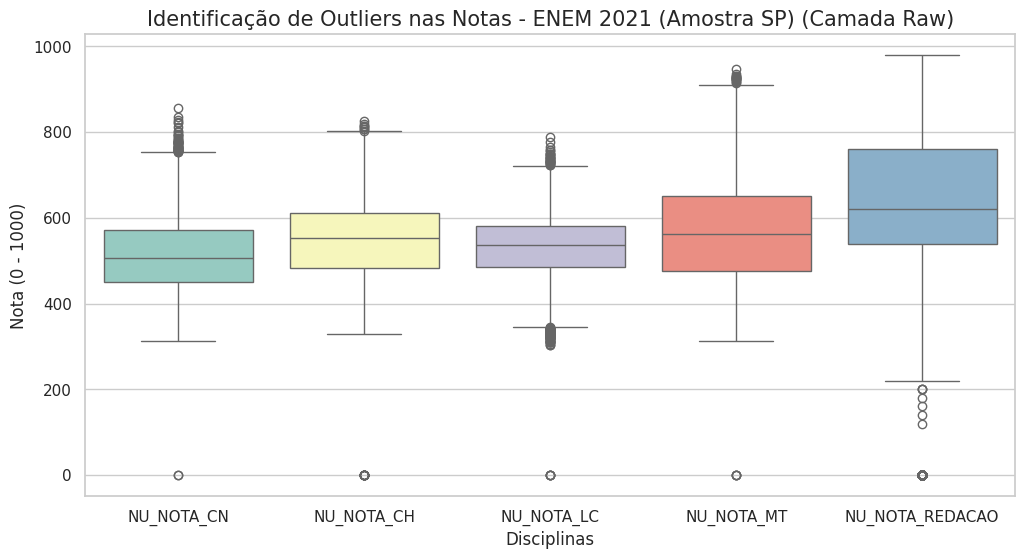

In [9]:
for col_name in df.columns:
    df = df.withColumnRenamed(col_name, col_name.upper())
    
df_presentes = df.filter(
    (df.TP_PRESENCA_CN == 1) & 
    (df.TP_PRESENCA_CH == 1) & 
    (df.TP_PRESENCA_LC == 1) & 
    (df.TP_PRESENCA_MT == 1)
)

coluna_notas = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"]
resumo_notas = df_presentes.select(coluna_notas).describe()

grafico_outlier = df_presentes.select(coluna_notas).sample(False, 0.05).toPandas()

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.boxplot(data=grafico_outlier, palette="Set3")

plt.title('Identificação de Outliers nas Notas - ENEM 2021 (Amostra SP) (Camada Raw)', fontsize=15)
plt.ylabel('Nota (0 - 1000)')
plt.xlabel('Disciplinas')
plt.show()

##### Explicação

Observou-se que, mesmo após o tratamento e filtragem na camada Silver, a presença de outliers na distribuição das notas permaneceu constante. Este fenômeno não decorre de inconsistências técnicas ou ruídos na coleta, mas sim das profundas disparidades socioeconômicas inerentes ao estado de São Paulo. A desigualdade no acesso à educação de qualidade reflete-se diretamente na dispersão dos dados. Portanto, esses valores atípicos não foram removidos, pois possuem valor analítico fundamental.

#### 2.4 Rating e dispersão

/tmp/ipykernel_8163/811396483.py:26: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')


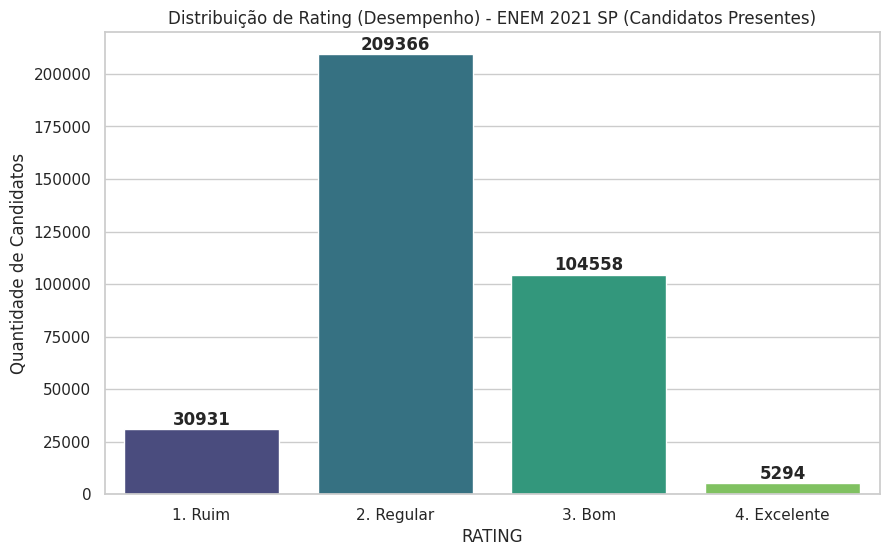

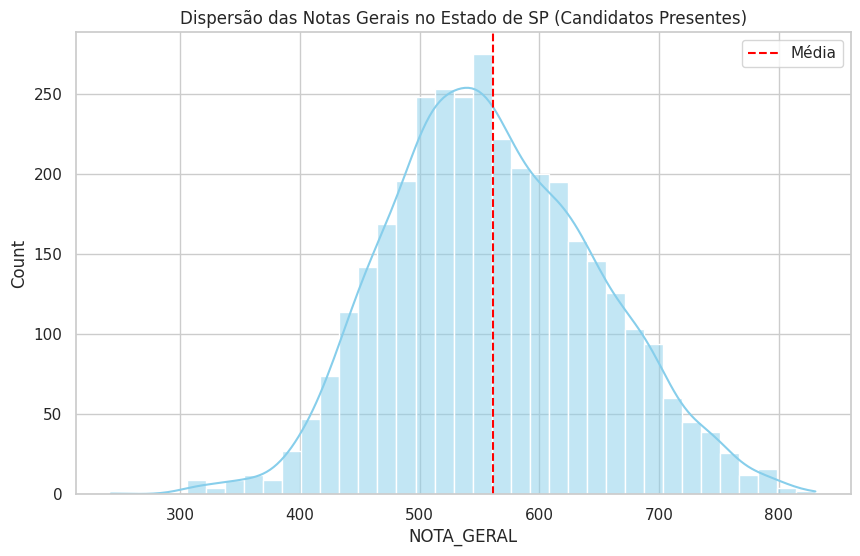

In [10]:
df_presentes = df.filter(
    (F.col("tp_presenca_cn") == 1) & 
    (F.col("tp_presenca_ch") == 1) & 
    (F.col("tp_presenca_lc") == 1) & 
    (F.col("tp_presenca_mt") == 1)
)

coluna_notas = ["nu_nota_cn", "nu_nota_ch", "nu_nota_lc", "nu_nota_mt", "nu_nota_redacao"]

media_SP_notas = df_presentes.withColumn("NOTA_GERAL", 
    (F.col("nu_nota_cn") + F.col("nu_nota_ch") + F.col("nu_nota_lc") + F.col("nu_nota_mt") + F.col("nu_nota_redacao")) / 5
)

media_SP_notas = media_SP_notas.withColumn("RATING",
    F.when(F.col("NOTA_GERAL") < 450, "1. Ruim")
     .when(F.col("NOTA_GERAL") < 600, "2. Regular")
     .when(F.col("NOTA_GERAL") < 750, "3. Bom")
     .otherwise("4. Excelente")
)

status_dispersao = media_SP_notas.select("NOTA_GERAL").summary("mean", "stddev", "min", "25%", "50%", "75%", "max")

status_rating = media_SP_notas.groupBy("RATING").count().orderBy("RATING").toPandas()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')
valores = status_rating['count'].values
for i, v in enumerate(valores):
    ax.text(i, v + (max(valores) * 0.01), str(int(v)), ha='center', fontweight='bold')

plt.title('Distribuição de Rating (Desempenho) - ENEM 2021 SP (Candidatos Presentes)')
plt.ylabel('Quantidade de Candidatos')
plt.show()

amostra_notas = media_SP_notas.select("NOTA_GERAL").sample(False, 0.01).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(amostra_notas['NOTA_GERAL'], kde=True, color='skyblue')
plt.axvline(amostra_notas['NOTA_GERAL'].mean(), color='red', linestyle='--', label='Média')
plt.title('Dispersão das Notas Gerais no Estado de SP (Candidatos Presentes)')
plt.legend()
plt.show()

##### Explicação

A análise de tendência central confirma que a média das notas no estado de São Paulo converge para os 500 pontos, validando a classificação da maioria dos candidatos no rating 'Regular'. A distribuição dos dados revela uma pirâmide de desempenho acentuada: enquanto quase 50% da base de candidatos situam-se no nível regular, apenas uma elite de aproximadamente 5% alcança o patamar 'Excelente'. Esta dispersão, observada de forma cristalina após o expurgo dos candidatos ausentes, ratifica a tese de que o desempenho acadêmico no estado é altamente concentrado, apresentando uma cauda estreita de alta performance.

#### 2.5 Outlier da idade dos estudantes do ENEM

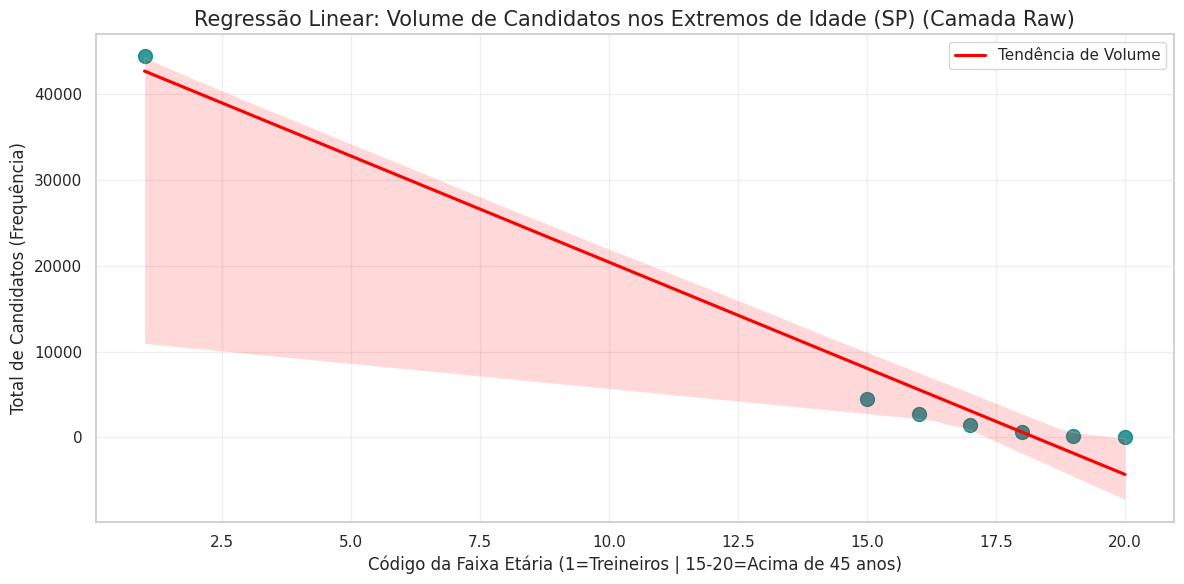

In [ ]:
faixa_etaria_estudantes = df.filter(F.col("SG_UF_PROVA") == "SP") \
    .select("TP_FAIXA_ETARIA", "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO") \
    .dropna()

outlier_idade = faixa_etaria_estudantes.filter((F.col("TP_FAIXA_ETARIA") == 1) | (F.col("TP_FAIXA_ETARIA") >= 15))

distribuicao_extremos = outlier_idade.groupBy("TP_FAIXA_ETARIA").count().orderBy("TP_FAIXA_ETARIA").toPandas()

plt.figure(figsize=(12, 6))

sns.regplot(
    data=distribuicao_extremos, 
    x="TP_FAIXA_ETARIA", 
    y="count", 
    color="teal",
    line_kws={"color": "red", "label": "Tendência de Volume"},
    scatter_kws={"s": 100}
)

plt.title('Regressão Linear: Volume de Candidatos nos Extremos de Idade (SP) (Camada Raw)', fontsize=15)
plt.xlabel('Código da Faixa Etária (1=Treineiros | 15-20=Acima de 45 anos)', fontsize=12)
plt.ylabel('Total de Candidatos (Frequência)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

##### Explicação

A regressão linear sobre os extremos etários revela que o volume de participantes em São Paulo segue uma tendência decrescente nítida à medida que a idade avança. Enquanto a faixa etária 1 concentra o maior volume de dados (jovens e treineiros), a linha de tendência para as faixas 15 a 20 prova que o reingresso sênior é um fenómeno estatisticamente consistente e não um ruído de processamento. Ao consolidar esta visão na camada Silver, asseguramos que a futura Camada Gold e o seu Star Schema operem sobre uma base fidedigna, onde a diversidade geracional pode ser correlacionada às notas sem a interferência de registos de ausentes, fornecendo insumos valiosos para o estudo do perfil demográfico real que concluiu o exame.